In [ ]:
# call %matplotlib only in a Jupiter notebook
%matplotlib inline 

# Common import
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tarfile

from pandas.plotting import scatter_matrix
from six.moves import urllib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, LabelBinarizer, LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor


In [131]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [132]:
def fetch_housing_data(housing_url=HOUSING_URL, 
                        housing_path=HOUSING_PATH):
    
        if not os.path.isdir(housing_path):
            os.makedirs(housing_path)
            
        tgz_path = os.path.join(housing_path, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
        
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()

In [133]:
def load_housing_data(housing_path=HOUSING_PATH):
    
    csv_path = os.path.join(housing_path, "housing.csv")
    return( pd.read_csv(csv_path) )

In [134]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return( data.iloc[train_indices], data.iloc[test_indices] )

In [135]:
def test_set_check(identifier, test_ratio, hash):
    hashed_id = hash(np.int64(identifier))
    return( hashed_id.digest()[-1] < (256 * test_ratio) )

In [136]:
def split_train_test_by_id(data, 
                           test_ratio, 
                           id_column, 
                           hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, 
                                                       test_ratio, 
                                                       hash))
    return( data.loc[~in_test_set], data.loc[in_test_set] )

In [278]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [137]:
# Although Scikit-Learn provides many useful transformers, 
# you will need to write your own for tasks such as custom 
# cleanup operations or combining specific attributes. 
#
# You will want your transformer to work seamlessly with 
# Scikit-Learn functionalities (such as pipelines), and 
# since Scikit-Learnrelies on duck typing (not inheritance), 
# all you need is to create a class and implement three 
# methods: fit() (returning self), transform(), and fit_transform(). 
#
# For more information reference page <To-Do: Add reference page number>
# 

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [138]:
# Now it would be nice if we could feed a Pandas DataFrame containing 
# non-numerical columns directly into our pipeline, instead of having 
# to first manually extract the numerical columns into a NumPy array. 
#
# There is nothing in Scikit-Learn to handle Pandas DataFrames 
# but we can write a custom transformer for this task:

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [266]:
# 
# Disclaimer this is NOT the actual code from the book or
# the CategoricalEncoder definition.
#
# I created this class to prove a concept and play with ideas.
# For the real code see the github account for the book.

from sklearn.base import BaseEstimator, TransformerMixin

encoder = LabelBinarizer()

class MyCategoricalEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return encoder.fit(X)
    def transform(self, X, y=None):
        return encoder.transform(X.reshape(-1,1))
    def fit_transform(self, X, y=None):
        return encoder.fit_transform(X.reshape(-1,1))

In [250]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [140]:
fetch_housing_data()
housing_data = load_housing_data()
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [141]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [142]:
housing_data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [143]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Visualize Yo Data!

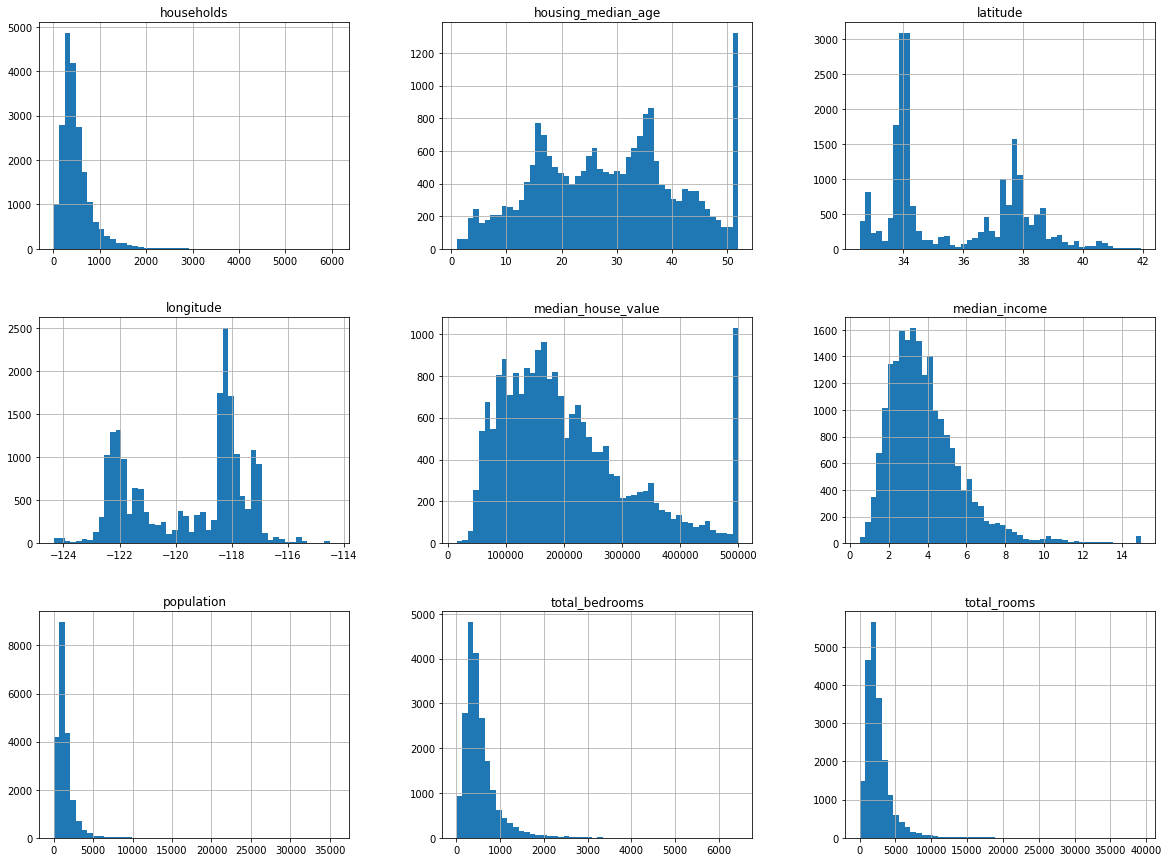

In [144]:
housing_data.hist(bins=50, figsize=(20, 15))
plt.show()

In [145]:
housing_data["income_cat"] = np.ceil(housing_data["median_income"] / 1.5)

# Add a values of 5.0 to the fields that return False to the
# condition. Otherwise, leave the current value in place
# get it; "inplace=True"; Soooo, leave the current value in place.
housing_data["income_cat"].where(housing_data["income_cat"] < 5, 
                                  5.0, 
                                  inplace=True)

housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


In [146]:
# create your training and testing set

# Alternative 1
# housing_with_id = housing_data.reset_index()
# train_set, test_set = split_train_test_by_id(housing_with_id, 
#                                              0.20, 
#                                              "index")

# The scikit-learn way
'''
There is no particular reason for using 42 as our random_state.
This number has no special property, other than to be "The Answer
to the Ultimate Question of Life, The Universe, and Everything"
'''
train_set, test_set = train_test_split(housing_data, 
                                       test_size=0.2, 
                                       random_state=42)

print( "{} train + {} test".format(len(train_set), 
                                   len(test_set)) )

16512 train + 4128 test


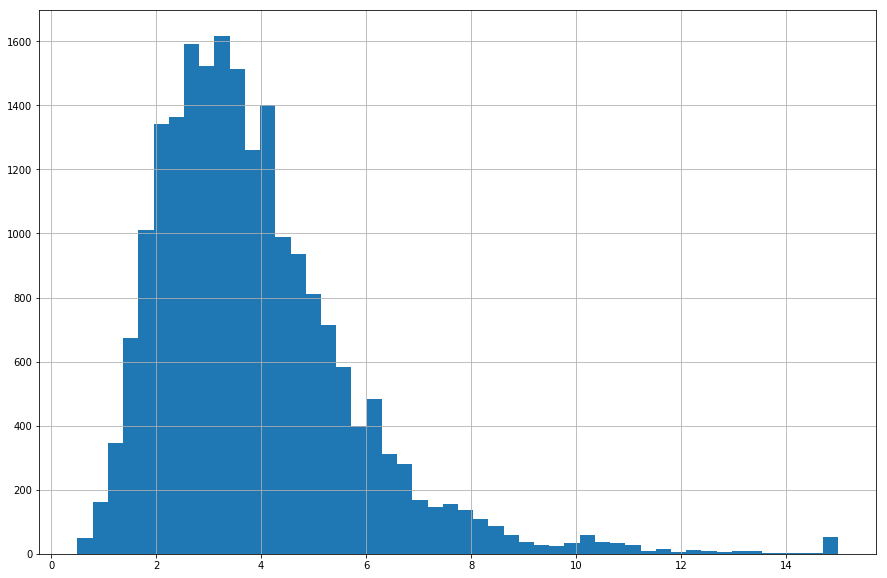

In [147]:
housing_data["median_income"].hist(bins=50, figsize=(15, 10))
plt.show()

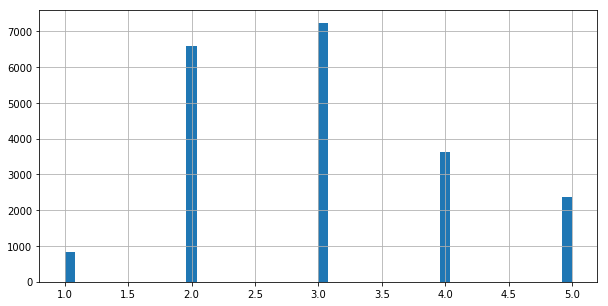

In [148]:
housing_data["income_cat"].hist(bins=50, figsize=(10, 5))
plt.show()

In [149]:
overall = housing_data["income_cat"].value_counts(sort=False) / len(housing_data)
random_train = train_set["income_cat"].value_counts(sort=False) / len(train_set)
random_test = test_set["income_cat"].value_counts(sort=False) / len(test_set)

In [150]:
split = StratifiedShuffleSplit(n_splits=1,
                               test_size=0.2,
                               random_state=42)

for train_index, test_index in split.split(housing_data, 
                                       housing_data["income_cat"]):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]
    
strat_train = (strat_train_set["income_cat"].value_counts(sort=False) / len(train_set) )
strat_test = (strat_test_set["income_cat"].value_counts(sort=False) / len(test_set) )

In [151]:
# Lets test the homogeneity of out train and test sets
# in relation to the overall data set
hg_test = pd.DataFrame()
hg_test['Overall'] = overall
hg_test['Random Train'] = random_train
hg_test['Strat Train'] = strat_train
hg_test['Random Test'] = random_test
hg_test['Strat Test'] = strat_test
hg_test['Rand. Train %error'] = ((overall - random_train) / overall * 100).values
hg_test['Strat Train %error'] = ((overall - strat_train) / overall * 100).values
hg_test['Rand. Test %error'] = (( overall - random_test) / overall * 100).values
hg_test['Strat Test %error'] = ((overall - strat_test) / overall * 100).values

In [152]:
# Here we can see that the stratified sample is a better
# data set do to how much more homogeneous it is.
hg_test.iloc[::-1]

,Overall,Random Train,Strat Train,Random Test,Strat Test,Rand. Train %error,Strat Train %error,Rand. Test %error,Strat Test %error
1.0,0.039826,0.039729,0.039850,0.040213,0.039729,-1.079594,0.031753,4.318374,-0.127011
2.0,0.318847,0.317466,0.318859,0.324370,0.318798,-1.264084,0.006870,5.056334,-0.027480
3.0,0.350581,0.348595,0.350594,0.358527,0.350533,0.566611,-0.003455,-2.266446,0.013820
4.0,0.176308,0.178537,0.176296,0.167393,0.176357,0.433065,-0.003799,-1.732260,0.015195
5.0,0.114438,0.115673,0.114402,0.109496,0.114583,0.243309,-0.060827,-0.973236,0.243309


In [153]:
# Now we should remove the "income_cat" field so the data is back
# to its original state:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [154]:
strat_test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND


In [155]:
# Copy the training set to avoid loosing it
housing = strat_train_set.copy()

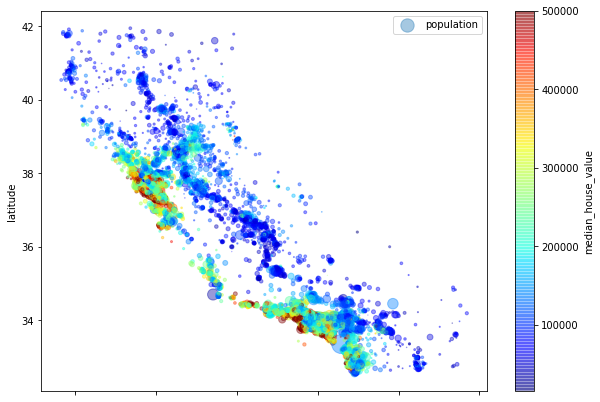

In [156]:
# Visualizing Geographical Data
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

# plt.legend()
plt.show()

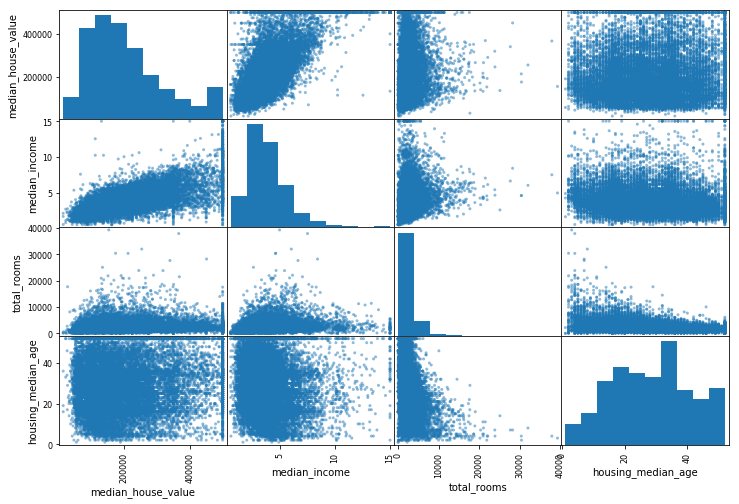

In [157]:
# Another way to look for correlations between attributes 
# is to use Pandas scatter_matrix function.
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

In [158]:
# Now lets look for correlations

'''
See how the median income has 68% correlation with the 
mediam house value. This means that that people with 
higher income tend to have more expensive houses.
Who would have thought, right! -_-

Also, take a look at the latitud. It has a marginal negative 
correlation with the median house value. This means that
People that live in lower latitudes (farther from north) tend
to have higher median_house_income.

We can corroborate all this information on the scatter graph above.
'''
corr_mattrix = housing.corr()
corr_mattrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

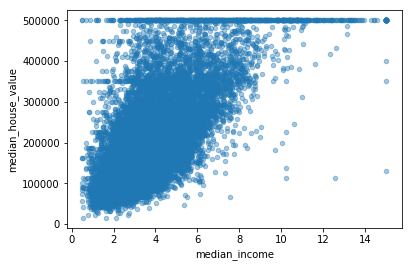

In [159]:
# median_house_value and median_income look promissing
# Lets take a closer look
housing.plot(kind="scatter", x="median_income", 
             y="median_house_value", alpha=0.4)
plt.show()

Can you see that dense horizontal line at 500K? These are 
the effect of capping the max mediam_house_value at 500K.

Also, 450K and 350K seem to display a similar behavior.  
I would recommend removing the corresponding districts 
to prevent our algorithms from reproducing these data quirks. 

 # Clean Yo Data!

In [160]:
# Copy the training set to avoid loosing it
# Create the labels set aka. the "Y" vector
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [161]:
# Most Machine Learning algorithms cannot work with missing features, 
# let's use sklearn to populte these empty vaues with the respective 
# median value of each feature
imputer = Imputer(strategy="median")

# Imputer only works with numeric data, so lets create a copy of 
# our training set without the ocean_proximity
housing_num = housing.drop(labels="ocean_proximity", axis=1)

X = imputer.fit_transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [162]:
# Lets make sure that we have transform our data properly
# The pandas DataFrame.describe() method should be good for this.
# describe() will not count those values that are missing
housing_tr.describe()

# Eureka! We can see that all the features have a count of 16,512.
# That is the same as the lenght of the training set.

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,533.998123,1419.790819,497.060380,3.875589
std,2.001860,2.138058,12.574726,2138.458419,410.839621,1115.686241,375.720845,1.904950
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,296.000000,784.000000,279.000000,2.566775
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900
75%,-118.010000,37.720000,37.000000,3141.000000,641.000000,1719.250000,602.000000,4.744475
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


## This is One-hot encoder!

In [163]:
# All jokes aside. Now that we removed all missing values from our
# training set feat. we can move to fixing those pesky text fields.

# Earlier we left out the categorical atribute ocean_proximity because
# it is a text atribute so we cannot compute its median. 
# In a nutshell, most machine learning algorithms work with numbers
# So we need to convert these text values into integer that we can use 
# to map back and forward.
 
# We can use the Scikit-Learn utility LabelEncoder for this task
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded


array([0, 0, 4, ..., 1, 0, 3])

In [164]:
# Awesome, now we have a numerical representaton of those text labels.
# The thing is, these numerical representations are not the best way 
# to deal with this kind of issue. Why you may ask?
# 
# Because Machine Learning Algorithms will assume that two near by
# values are more similar than two distant values. 
#
# A Common aproach to solving this issue it to represent the categories
# in a binary fashion, where we use 1 if it is "<1H OCEAN" and 0 otherwise.
# Because we have 5 catergories, we will need an array to represent each one.
# Ex:
#    "<1H OCEAN" = [1, 0, 0, 0, 0]
#    "INLAND" = [0, 1, 0, 0, 0]
#    "ISALAN" = [0, 0, 0, 1, 0]
#    etc...
#
# This is called "one-hot encoding", because only 1 atribute will be 
# equal to 1 (hot), while all others will be cero (cold).
# 
print(encoder.classes_)


['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [165]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [166]:
# Im a bit sleepy right now, I have nothing witty to say
# See page 64 of the book for more info.
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [267]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()) ])

# CategoricalEncoder is still not available in this version
# So I will re-use LabelBinarizer
#
# cat_pipeline = Pipeline([
#        ('selector', DataFrameSelector(cat_attribs)),
#        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")) ])

cat_pipeline = Pipeline([
       ('selector', DataFrameSelector(cat_attribs)),
       ('cat_encoder', MyCategoricalEncoder()) ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline) ])

# Return a numpy array
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [268]:
housing_prepared.shape

(16512, 16)

 # Pick Yo Model!

## Linear Regresion Model

In [269]:
# Lest Train a Linear Regresion Model 
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [275]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

print("Predictions: {}".format(lin_reg.predict(some_data_prepared)))
print("Labels: {}".format(list(some_labels)))
print("Root Mean Squared Error (RMSE): {}".format(lin_rmse))

# We have an error margin of 68,628; Not too good.
# Let's try a NonLinearModel Model; Let's try DecisionTreeRegresor

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]
Root Mean Squared Error (RMSE): 68628.19819848923


## DecisionTreeRegresor

In [287]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

print("Predictions: {}".format(lin_reg.predict(some_data_prepared)))
print("Labels: {}".format(list(some_labels)))
print("Root Mean Squared Error (RMSE): {}".format(tree_rmse))
      
# OMG we have 0% error! We have created a perfect model.
# AKA. we have overfitted our data! #ZadBoyz

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]
Root Mean Squared Error (RMSE): 0.0
0.0


## Evaluating the right way with CrossValidation

## Non Linear Regrssion Model

In [294]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [ 69182.11990772  66672.25248465  70839.62410331  70957.35815257
  72151.7058427   75835.80651255  71099.19822963  70131.90315325
  76975.52465193  70539.38023162]
Mean: 71438.487327
Standard deviation: 2855.39599388


## Linear Regression Model

In [295]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018


In [299]:
forest_reg = RandomForestRegressor()
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 51030.86009873  51170.53302232  51736.30850485  54147.94625978
  52541.19818957  55593.47149177  51852.43078403  50455.18201089
  55857.05787836  52643.83160858]
Mean: 52702.8819849
Standard deviation: 1796.54139559


# Fine-Tune Your Model

In [300]:
# To-Do